In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
from scipy.stats import gaussian_kde
from astropy.cosmology import Planck18 as cosmo
from scipy.spatial import cKDTree

import matplotlib
from matplotlib import pyplot as plt

import fitsio
from scipy.spatial.distance import cdist

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity  

from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


## kNN method

## 1. DESI, SDSS, Quaia triple considered

In [2]:
superset = fits.open('Quaia_DESIQSO_DR1_SDSS.fits')
data = superset[1].data

train_mask = (~np.isnan(data['DESI_Z']))
train_data = data[train_mask]

print("train_data 개수:", np.sum(train_mask))

train_data 개수: 314807


In [3]:
features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg',
            'Quaia_W12'
            ]

valid_mask = (~np.isnan(data['DESI_Z'])) & (~np.isnan(data['SDSS_Z']))
filtered_data = data[valid_mask]

X_train = np.array([filtered_data[f] for f in features]).T
y_train = filtered_data['redshift_quaia']
#y_train = np.where(~np.isnan(filtered_data['DESI_Z']), 
#                   filtered_data['redshift_quaia'],
#                   filtered_data['DESI_Z']) 
X_test = np.array([filtered_data[f] for f in features]).T
y_test = filtered_data['DESI_Z']


print("X_train NaN 개수:", np.isnan(X_train).sum())
print("X_test NaN 개수:", np.isnan(X_test).sum())
print("X_test shape:", X_test.shape)
print("각 feature 별 NaN 개수:", np.isnan(X_test).sum(axis=0))
print("test_mask에서 True 개수:", np.sum(valid_mask))
print(filtered_data.shape)

X_train NaN 개수: 0
X_test NaN 개수: 0
X_test shape: (101233, 6)
각 feature 별 NaN 개수: [0 0 0 0 0 0]
test_mask에서 True 개수: 101233
(101233,)


kNN 1. cKDTree
    2. kNeighborRegressor

cKDTree : redshifts are predicted within the priorities of each sets. for now, distance-based weight applied (Gaussian) and normalized.

In [4]:
%load_ext memory_profiler
%memit

K = 11

nan_mask_test = np.isnan(X_test).any(axis=1)
X_test_clean = X_test[~nan_mask_test]

nan_mask = np.isnan(X_train).any(axis=1)  # NaN이 있는 행 찾기

X_train_clean = X_train[~nan_mask]  # NaN 없는 데이터만 선택
y_train_clean = y_train[~nan_mask]

tree = cKDTree(X_train_clean)
dists, inds = tree.query(X_test_clean, k=K)

# 거리 기반 가중치 적용 (가까울수록 더 높은 가중치)
#sigma = np.median(dists)  # 거리의 중앙값을 기준으로 스케일 조정
#weights = np.exp(-dists**2 / (2 * sigma**2))  # 가우시안 가중치 적용
#weights /= np.sum(weights, axis=1, keepdims=True)  # 정규화
#z_phot_predictions = np.sum(y_train_clean[inds] * weights, axis=1)

Y_neighbors = y_train_clean[inds]
# 모든 이웃에게 동일한 가중치 부여
weights = np.full_like(Y_neighbors, fill_value=1 / K, dtype=np.float64)

z_phot_predictions = np.sum(Y_neighbors * weights, axis=1)

# 결과 확인
count = 0  # 출력된 개수 카운트
max_print = 5  # 최대 출력 개수

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test] 

for i, pred in zip(valid_test_indices, z_phot_predictions):
    quaia = data['redshift_quaia'][i]
    desi = data['DESI_Z'][i]
    
    if not (np.isnan(pred) or np.isnan(quaia) or np.isnan(desi)):
        print(f"예측된 redshift: {pred}\nQuaia redshift: {quaia}\nDESI redshift: {desi}\n")
        count += 1

    if count >= max_print:
        break

peak memory: 690.01 MiB, increment: 0.21 MiB
예측된 redshift: 2.4258104507272895
Quaia redshift: 2.4226319789886475
DESI redshift: 2.424188775557774

예측된 redshift: 2.352495876225558
Quaia redshift: 2.852853775024414
DESI redshift: 2.869778073634424

예측된 redshift: 0.822273850440979
Quaia redshift: 0.821638286113739
DESI redshift: 0.8104069564257644

예측된 redshift: 0.7407543302589593
Quaia redshift: 0.4740816652774811
DESI redshift: 0.4708462042020013

예측된 redshift: 1.758356899694963
Quaia redshift: 1.8770912885665894
DESI redshift: 1.8636456256865628



In [5]:
header = superset[1].header  

print("z_phot_predictions shape:", z_phot_predictions.shape)
print("z_phot_predictions sample:", z_phot_predictions[:10])

print("test_mask에서 True 개수:", np.sum(valid_mask))
print("X_test_clean shape:", X_test_clean.shape)

new_col_zphot = np.full(data.shape[0], np.nan) 
new_col_err = np.full(data.shape[0], np.nan)

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test]  

# 예측된 값 채우기
new_col_zphot[valid_test_indices] = z_phot_predictions
#new_col_err[valid_test_indices] = sigma_z

new_cols = fits.ColDefs([
    fits.Column(name='Photo_z_QD', format='E', array=new_col_zphot)
    #fits.Column(name='Photo_z_QD_err', format='E', array=new_col_err)
])

hdu = fits.BinTableHDU.from_columns(data.columns + new_cols, header=header)

#hdu.writeto("superset_with_zphot_new2.fits", overwrite=True)
hdu.writeto("superset_with_z1.fits", overwrite=True)


z_phot_predictions shape: (101233,)
z_phot_predictions sample: [2.42581045 2.35249588 0.82227385 0.74075433 1.7583569  0.34826575
 1.5909593  2.19578915 1.8379489  0.98618499]
test_mask에서 True 개수: 101233
X_test_clean shape: (101233, 6)


## 1-1. knn method from Quaia used with KNeighborsRegressor

In [6]:
%load_ext memory_profiler
%memit

# X_test NaN 처리
imputer = SimpleImputer(strategy='mean')  # 평균값으로 NaN 대체

# 스케일링
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 스케일링 확인
for name, mean, var in zip(features, scaler.mean_, scaler.var_):
    print(f"{name}: mean = {mean:.4f}, std = {np.sqrt(var):.4f}")

#knn = KNeighborsRegressor(n_neighbors=11, weights='distance', metric='euclidean')
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='euclidean')
knn.fit(X_train, y_train)

# kNN 예측
z_phot_predictions1 = knn.predict(X_test)

y_pred_train = knn.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
print(z_phot_predictions1[:5])

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 1244.31 MiB, increment: 0.00 MiB
phot_g_mean_mag: mean = 19.7484, std = 0.6290
phot_bp_mean_mag: mean = 19.9423, std = 0.6279
phot_rp_mean_mag: mean = 19.3031, std = 0.6241
mag_w1_vg: mean = 16.1214, std = 0.7895
mag_w2_vg: mean = 15.0626, std = 0.8253
Quaia_W12: mean = 1.0588, std = 0.2042
MAE: 0.2130, RMSE: 0.2931
[2.50913719 2.56273694 0.80198671 0.78202204 1.66593959]


/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
# 결과 확인
count = 0  # 출력된 개수 카운트
max_print = 5  # 최대 출력 개수

for pred, quaia, desi, sdss in zip(z_phot_predictions1, 
                                   data['redshift_quaia'], 
                                   data['DESI_Z'], 
                                   data['SDSS_Z']):
    if not (np.isnan(pred) or np.isnan(quaia) or np.isnan(desi) or np.isnan(sdss)):
        print(f"predicted redshift: {pred}\nQuaia redshift: {quaia}\nDESI redshift: {desi}\nSDSS redshift: {sdss}\n")
        count += 1
    
    if count >= max_print:
        break  

predicted redshift: 0.7820220443704395
Quaia redshift: 2.4226319789886475
DESI redshift: 2.424188775557774
SDSS redshift: 2.414

predicted redshift: 1.6659395933151244
Quaia redshift: 2.852853775024414
DESI redshift: 2.869778073634424
SDSS redshift: 2.863

predicted redshift: 1.6753223896026612
Quaia redshift: 0.821638286113739
DESI redshift: 0.8104069564257644
SDSS redshift: 0.8101370334625244

predicted redshift: 2.121718740463257
Quaia redshift: 0.4740816652774811
DESI redshift: 0.4708462042020013
SDSS redshift: 0.4703986942768097

predicted redshift: 2.0974096223128784
Quaia redshift: 1.8770912885665894
DESI redshift: 1.8636456256865628
SDSS redshift: 1.8628448247909546



In [8]:
header = superset[1].header  

new_col_zphot1 = np.full(data.shape[0], np.nan) 
test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test]  

# 예측된 값 채우기
new_col_zphot1[valid_test_indices] = z_phot_predictions1

new_cols1 = fits.ColDefs([
    fits.Column(name='Photo_z_QD', format='E', array=new_col_zphot1)
    #fits.Column(name='Photo_z_QD_err', format='E', array=new_col_err)
])

hdu = fits.BinTableHDU.from_columns(data.columns + new_cols1, header=header)

#hdu.writeto("superset_with_zphot_kNR2.fits", overwrite=True)


In [9]:
print("X_train min/max:", np.nanmin(X_train, axis=0), np.nanmax(X_train, axis=0))
print("X_test min/max:", np.nanmin(X_test, axis=0), np.nanmax(X_test, axis=0))

nan_percentage = (np.isnan(X_train).sum() / X_train.size) * 100
print(f"NaN 비율: {nan_percentage:.2f}%")

X_train min/max: [-5.72399926 -5.78397462 -5.88729548 -6.77170957 -6.35552409 -3.22239751] [1.19484871 2.47570221 2.54454371 2.68028239 2.53848429 5.82568514]
X_test min/max: [-5.72399926 -5.78397462 -5.88729548 -6.77170957 -6.35552409 -3.22239751] [1.19484871 2.47570221 2.54454371 2.68028239 2.53848429 5.82568514]
NaN 비율: 0.00%


In [10]:
import pandas as pd

df_train = pd.DataFrame(X_train_clean, columns=features)
print(df_train.describe())

df_test = pd.DataFrame(X_test_clean, columns=features)
print(df_test.describe())


       phot_g_mean_mag  phot_bp_mean_mag  phot_rp_mean_mag      mag_w1_vg  \
count    101233.000000     101233.000000     101233.000000  101233.000000   
mean         19.748435         19.942266         19.303089      16.121418   
std           0.629001          0.627921          0.624093       0.789483   
min          16.148048         16.310406         15.628886      10.775292   
25%          19.432995         19.639645         19.001337      15.657100   
50%          19.905317         20.097816         19.450762      16.220512   
75%          20.230364         20.393494         19.755798      16.692911   
max          20.499992         21.496803         20.891113      18.237446   

           mag_w2_vg      Quaia_W12  
count  101233.000000  101233.000000  
mean       15.062639       1.058779  
std         0.825282       0.204226  
min         9.817562       0.400685  
25%        14.582445       0.925600  
50%        15.135695       1.069569  
75%        15.647404       1.202262  
ma

In [11]:
# NaN이 있는 데이터 제거
desi_z_clean = data['DESI_Z'][valid_mask][~nan_mask_test]  

# 차이 계산
diff = np.abs(z_phot_predictions - desi_z_clean)

print("평균 차이:", np.mean(diff))
print("중앙값 차이:", np.median(diff))
print("최대 차이:", np.max(diff))

quaia_vs_desi_diff = np.abs(data['redshift_quaia'] - data['DESI_Z'])

print(f"Quaia vs. DESI 평균 차이: {np.nanmean(quaia_vs_desi_diff)}")
print(f"Quaia vs. DESI 중앙값 차이: {np.nanmedian(quaia_vs_desi_diff)}")
print(f"Quaia vs. DESI 최대 차이: {np.nanmax(quaia_vs_desi_diff)}")

quaia_vs_photoz_diff = np.abs(data['redshift_quaia'] - new_col_zphot)

print(f"Quaia vs. kNN Photo-z 평균 차이: {np.nanmean(quaia_vs_photoz_diff)}")
print(f"Quaia vs. kNN Photo-z 중앙값 차이: {np.nanmedian(quaia_vs_photoz_diff)}")
print(f"Quaia vs. kNN Photo-z 최대 차이: {np.nanmax(quaia_vs_photoz_diff)}")

quaia_vs_photoz_diff2 = np.abs(data['redshift_quaia'] - new_col_zphot1)

print(f"Quaia vs. kNN Photo-z2 평균 차이: {np.nanmean(quaia_vs_photoz_diff2)}")
print(f"Quaia vs. kNN Photo-z2 중앙값 차이: {np.nanmedian(quaia_vs_photoz_diff2)}")
print(f"Quaia vs. kNN Photo-z2 최대 차이: {np.nanmax(quaia_vs_photoz_diff2)}")

평균 차이: 0.25732256532106584
중앙값 차이: 0.1865355391246295
최대 차이: 4.511739466675945
Quaia vs. DESI 평균 차이: 0.1247888796360761
Quaia vs. DESI 중앙값 차이: 0.01571005305700246
Quaia vs. DESI 최대 차이: 4.794040567381018
Quaia vs. kNN Photo-z 평균 차이: 0.22827902546764836
Quaia vs. kNN Photo-z 중앙값 차이: 0.16457871393723944
Quaia vs. kNN Photo-z 최대 차이: 2.193639966255731
Quaia vs. kNN Photo-z2 평균 차이: 0.21302583384046103
Quaia vs. kNN Photo-z2 중앙값 차이: 0.1530168498254807
Quaia vs. kNN Photo-z2 최대 차이: 2.009690046029836


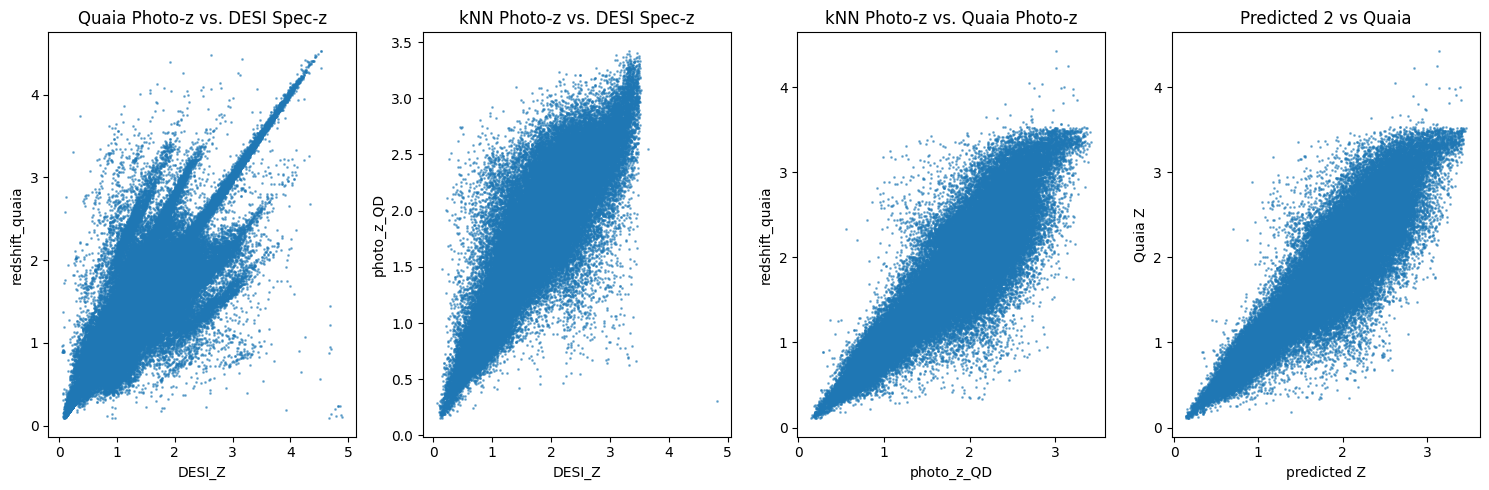

In [12]:
plt.figure(figsize=(15, 5))

# 1. Quaia vs. DESI
plt.subplot(1, 4, 1)
plt.scatter(data['DESI_Z'], data['redshift_quaia'], alpha=0.5, s=1)
plt.xlabel("DESI_Z")
plt.ylabel("redshift_quaia")
plt.title("Quaia Photo-z vs. DESI Spec-z")

# 2. kNN Photo-z vs. DESI
plt.subplot(1, 4, 2)
plt.scatter(data['DESI_Z'], new_col_zphot, alpha=0.5, s=1)
plt.xlabel("DESI_Z")
plt.ylabel("photo_z_QD")
plt.title("kNN Photo-z vs. DESI Spec-z")

# 3. kNN Photo-z vs. Quaia
plt.subplot(1, 4, 3)
plt.scatter(new_col_zphot, data['redshift_quaia'], alpha=0.5, s=1)
plt.xlabel("photo_z_QD")
plt.ylabel("redshift_quaia")
plt.title("kNN Photo-z vs. Quaia Photo-z")

# 4. kNN z ver.2 vs DESI
plt.subplot(1, 4, 4)
plt.scatter(new_col_zphot1, data['redshift_quaia'], alpha=0.5, s=1)
plt.xlabel("predicted Z")
plt.ylabel("Quaia Z")
plt.title("Predicted 2 vs Quaia")

plt.tight_layout()
plt.show()


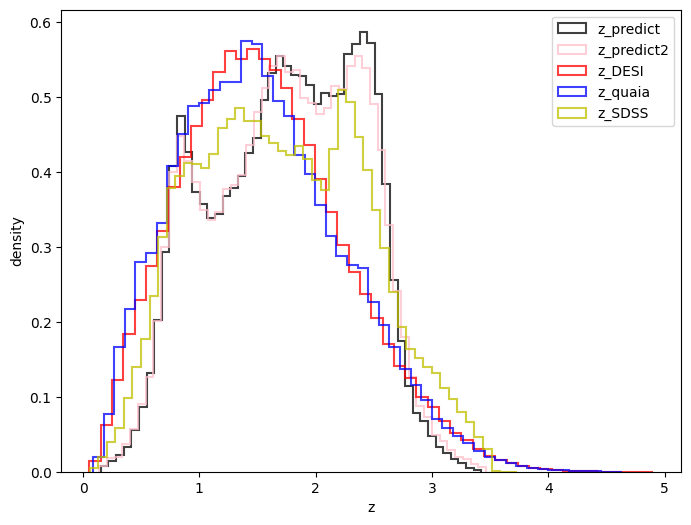

In [13]:
#히스토그램
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(new_col_zphot, bins=50, alpha=alpha, color='black', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(new_col_zphot1, bins=50, alpha=alpha, color='pink', lw=lw, density=density, histtype=histtype, label='z_predict2')
plt.hist(data['DESI_Z'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_DESI')
plt.hist(data['redshift_quaia'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_quaia')
plt.hist(data['SDSS_Z'], bins=50, alpha=alpha, color='y', lw=lw, density=density, histtype=histtype, label='z_SDSS')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

# 2. Sepearated consider

Quaia only, 
DESI only, 
SDSS only, 

each of them will be tested with kNN method, so that I can compare each.

Quaia only considered

In [14]:
train_mask = (~np.isnan(data['redshift_quaia']))
train_data = data[train_mask]

print("train_data 개수:", np.sum(train_mask))

train_data 개수: 1295502


In [63]:
features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg',
            'Quaia_W12'
            ]

valid_mask = (~np.isnan(data['redshift_quaia']))
filtered_data = data[valid_mask]

X_train = np.array([filtered_data[f] for f in features]).T
y_train = filtered_data['redshift_quaia']
#y_train = np.where(~np.isnan(filtered_data['DESI_Z']), 
#                   filtered_data['DESI_Z'],  # DESI redshift 우선
#                   filtered_data['redshift_quaia'])  # 없으면 Quaia redshift 사용

X_test = np.array([filtered_data[f] for f in features]).T
#y_test = filtered_data['DESI_Z']

print("X_train NaN 개수:", np.isnan(X_train).sum())

print("X_test NaN 개수:", np.isnan(X_test).sum())
print("X_test shape:", X_test.shape)
print("각 feature 별 NaN 개수:", np.isnan(X_test).sum(axis=0))
print("test_mask에서 True 개수:", np.sum(valid_mask))

X_train NaN 개수: 0
X_test NaN 개수: 0
X_test shape: (1295502, 6)
각 feature 별 NaN 개수: [0 0 0 0 0 0]
test_mask에서 True 개수: 1295502


In [64]:
%load_ext memory_profiler
%memit

K = 11

nan_mask_test = np.isnan(X_test).any(axis=1)
X_test_clean = X_test[~nan_mask_test]

nan_mask = np.isnan(X_train).any(axis=1)  # NaN이 있는 행 찾기

X_train_clean = X_train[~nan_mask]  # NaN 없는 데이터만 선택
y_train_clean = y_train[~nan_mask]

tree = cKDTree(X_train_clean)
dists, inds = tree.query(X_test_clean, k=K)

# 거리 기반 가중치 적용 (가까울수록 더 높은 가중치)
#sigma = np.median(dists)  # 거리의 중앙값을 기준으로 스케일 조정
#weights = np.exp(-dists**2 / (2 * sigma**2))  # 가우시안 가중치 적용
#weights /= np.sum(weights, axis=1, keepdims=True)  # 정규화
#z_phot_predictions = np.sum(y_train_clean[inds] * weights, axis=1)

Y_neighbors = y_train_clean[inds]
# 모든 이웃에게 동일한 가중치 부여
weights = np.full_like(Y_neighbors, fill_value=1 / K, dtype=np.float64)

z_phot_predictions = np.sum(Y_neighbors * weights, axis=1)

# 결과 확인
count = 0  # 출력된 개수 카운트
max_print = 5  # 최대 출력 개수

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test] 

for i, pred in zip(valid_test_indices, z_phot_predictions):
    quaia = data['redshift_quaia'][i]
    desi = data['DESI_Z'][i]
    
    if not (np.isnan(pred) or np.isnan(quaia) or np.isnan(desi)):
        print(f"예측된 redshift: {pred}\nQuaia redshift: {quaia}\nDESI redshift: {desi}\n")
        count += 1

    if count >= max_print:
        break

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 2031.36 MiB, increment: 0.05 MiB
예측된 redshift: 0.3828495245406403
Quaia redshift: 0.41686686873435974
DESI redshift: 0.4099723683396368

예측된 redshift: 1.684889858419245
Quaia redshift: 1.7364680767059326
DESI redshift: 1.7403967224566679

예측된 redshift: 1.4112802310423418
Quaia redshift: 1.5130492448806763
DESI redshift: 1.5029969100152152

예측된 redshift: 2.415698204994202
Quaia redshift: 2.4226319789886475
DESI redshift: 2.424188775557774

예측된 redshift: 2.3783330769972366
Quaia redshift: 2.852853775024414
DESI redshift: 2.869778073634424



In [65]:
%load_ext memory_profiler
%memit

# X_test NaN 처리
imputer = SimpleImputer(strategy='mean')  # 평균값으로 NaN 대체

# 스케일링
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 스케일링 확인
for name, mean, var in zip(features, scaler.mean_, scaler.var_):
    print(f"{name}: mean = {mean:.4f}, std = {np.sqrt(var):.4f}")

#knn = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='euclidean')
knn = KNeighborsRegressor(n_neighbors=11, weights='uniform', metric='euclidean')
knn.fit(X_train, y_train)

# kNN 예측
z_phot_predictions1 = knn.predict(X_test)

y_pred_train = knn.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
print(z_phot_predictions1[:5])

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 2725.04 MiB, increment: 0.00 MiB
phot_g_mean_mag: mean = 19.7056, std = 0.6650
phot_bp_mean_mag: mean = 19.8970, std = 0.6692
phot_rp_mean_mag: mean = 19.2151, std = 0.6707
mag_w1_vg: mean = 15.8877, std = 0.8733
mag_w2_vg: mean = 14.8198, std = 0.8914
Quaia_W12: mean = 1.0679, std = 0.2123
MAE: 0.2096, RMSE: 0.2982
[0.41804132 1.62727652 1.42689129 2.4441214  2.34321707]


/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
header = superset[1].header  

print("z_phot_predictions shape:", z_phot_predictions1.shape)
print("z_phot_predictions sample:", z_phot_predictions1[:10])

print("test_mask에서 True 개수:", np.sum(valid_mask))
print("X_test_clean shape:", X_test_clean.shape)

new_col_zphot = np.full(data.shape[0], np.nan) 
new_col_err = np.full(data.shape[0], np.nan)

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test]  

# 예측된 값 채우기
new_col_zphot[valid_test_indices] = z_phot_predictions1
#new_col_err[valid_test_indices] = sigma_z

new_cols = fits.ColDefs([
    fits.Column(name='Photo_z_QD', format='E', array=new_col_zphot)
    #fits.Column(name='Photo_z_QD_err', format='E', array=new_col_err)
])

hdu = fits.BinTableHDU.from_columns(data.columns + new_cols, header=header)

hdu.writeto("superset_with_zphot_new3.fits", overwrite=True)


z_phot_predictions shape: (1295502,)
z_phot_predictions sample: [0.38385393 1.69592345 1.39663637 2.34673314 2.51074305 1.43202202
 0.66146745 0.72468829 2.36714964 1.11963253]
test_mask에서 True 개수: 1295502
X_test_clean shape: (1295502, 6)


In [19]:
new3 = fits.open("superset_with_zphot_new3.fits")
data3 = new3[1].data

redshift = data3['Photo_z_QD']

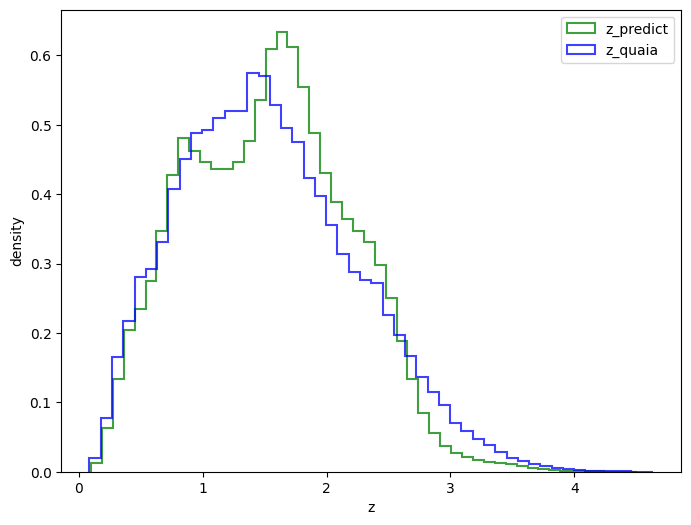

In [20]:
#히스토그램
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(redshift, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(data['redshift_quaia'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_quaia')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

DESI only

In [40]:
train_mask = (~np.isnan(data['DESI_Z'])) 
train_data = data[train_mask]

print("train_data 개수:", np.sum(train_mask))

features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg',
            'Quaia_W12'
            ]

valid_mask = (~np.isnan(data['DESI_Z'])) 
filtered_data = data[valid_mask]

X_train = np.array([filtered_data[f] for f in features]).T
y_train = filtered_data['DESI_Z']

X_test = np.array([filtered_data[f] for f in features]).T
# y_test = filtered_data['DESI_Z']    #doesn't need to be.. as I don't use it in the code practically.


print("X_train NaN 개수:", np.isnan(X_train).sum())
print("X_test NaN 개수:", np.isnan(X_test).sum())
print("X_test shape:", X_test.shape)
print("각 feature 별 NaN 개수:", np.isnan(X_test).sum(axis=0))
print("test_mask에서 True 개수:", np.sum(valid_mask))
print(filtered_data.shape)

# print(y_test)
print(y_train)

train_data 개수: 314807
X_train NaN 개수: 0
X_test NaN 개수: 0
X_test shape: (314807, 6)
각 feature 별 NaN 개수: [0 0 0 0 0 0]
test_mask에서 True 개수: 314807
(314807,)
[0.40997237 1.74039672 1.50299691 ... 0.43487528 3.03919766 2.54033311]
[0.40997237 1.74039672 1.50299691 ... 0.43487528 3.03919766 2.54033311]


In [41]:
%load_ext memory_profiler
%memit

K = 11

nan_mask_test = np.isnan(X_test).any(axis=1)
X_test_clean = X_test[~nan_mask_test]

nan_mask = np.isnan(X_train).any(axis=1)  # NaN이 있는 행 찾기

X_train_clean = X_train[~nan_mask]  # NaN 없는 데이터만 선택
y_train_clean = y_train[~nan_mask]

tree = cKDTree(X_train_clean)
dists, inds = tree.query(X_test_clean, k=K)

# 거리 기반 가중치 적용 (가까울수록 더 높은 가중치)
#sigma = np.median(dists)  # 거리의 중앙값을 기준으로 스케일 조정
#weights = np.exp(-dists**2 / (2 * sigma**2))  # 가우시안 가중치 적용
#weights /= np.sum(weights, axis=1, keepdims=True)  # 정규화
#z_phot_predictions = np.sum(y_train_clean[inds] * weights, axis=1)

Y_neighbors = y_train_clean[inds]
# 모든 이웃에게 동일한 가중치 부여
weights = np.full_like(Y_neighbors, fill_value=1 / K, dtype=np.float64)

z_phot_predictions = np.sum(Y_neighbors * weights, axis=1)

# 결과 확인
count = 0  # 출력된 개수 카운트
max_print = 5  # 최대 출력 개수

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test] 

for i, pred in zip(valid_test_indices, z_phot_predictions):
    quaia = data['redshift_quaia'][i]
    desi = data['DESI_Z'][i]
    
    if not (np.isnan(pred) or np.isnan(quaia) or np.isnan(desi)):
        print(f"예측된 redshift: {pred}\nQuaia redshift: {quaia}\nDESI redshift: {desi}\n")
        count += 1

    if count >= max_print:
        break

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 1753.98 MiB, increment: 0.05 MiB
예측된 redshift: 0.37773804917987075
Quaia redshift: 0.41686686873435974
DESI redshift: 0.4099723683396368

예측된 redshift: 1.701188455844188
Quaia redshift: 1.7364680767059326
DESI redshift: 1.7403967224566679

예측된 redshift: 1.4250080699727221
Quaia redshift: 1.5130492448806763
DESI redshift: 1.5029969100152152

예측된 redshift: 2.2722984630680942
Quaia redshift: 2.4226319789886475
DESI redshift: 2.424188775557774

예측된 redshift: 2.158244609958177
Quaia redshift: 2.852853775024414
DESI redshift: 2.869778073634424



In [42]:
%load_ext memory_profiler
%memit

# X_test NaN 처리
imputer = SimpleImputer(strategy='mean')  # 평균값으로 NaN 대체

# 스케일링
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 스케일링 확인
for name, mean, var in zip(features, scaler.mean_, scaler.var_):
    print(f"{name}: mean = {mean:.4f}, std = {np.sqrt(var):.4f}")

#knn = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='euclidean')
knn = KNeighborsRegressor(n_neighbors=11, weights='uniform', metric='euclidean')
knn.fit(X_train, y_train)

# kNN 예측
z_phot_predictions2 = knn.predict(X_test)

y_pred_train = knn.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
print(z_phot_predictions2[:5])

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 1851.94 MiB, increment: 0.00 MiB
phot_g_mean_mag: mean = 19.6964, std = 0.6684
phot_bp_mean_mag: mean = 19.8850, std = 0.6723
phot_rp_mean_mag: mean = 19.2259, std = 0.6658
mag_w1_vg: mean = 15.9457, std = 0.8495
mag_w2_vg: mean = 14.8706, std = 0.8730
Quaia_W12: mean = 1.0751, std = 0.2074
MAE: 0.2314, RMSE: 0.3252
[0.39159609 1.65350376 1.40809234 2.42014209 2.23898544]


/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [43]:
header = superset[1].header  

print("z_phot_predictions shape:", z_phot_predictions2.shape)
print("z_phot_predictions sample:", z_phot_predictions2[:10])

print("test_mask에서 True 개수:", np.sum(valid_mask))
print("X_test_clean shape:", X_test_clean.shape)

new_col_zphot = np.full(data.shape[0], np.nan) 
new_col_err = np.full(data.shape[0], np.nan)

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test]  

# 예측된 값 채우기
new_col_zphot[valid_test_indices] = z_phot_predictions2
#new_col_err[valid_test_indices] = sigma_z

new_cols = fits.ColDefs([
    fits.Column(name='Photo_z_QD', format='E', array=new_col_zphot)
    #fits.Column(name='Photo_z_QD_err', format='E', array=new_col_err)
])

hdu = fits.BinTableHDU.from_columns(data.columns + new_cols, header=header)

hdu.writeto("superset_with_zphot_new4.fits", overwrite=True)


z_phot_predictions shape: (314807,)
z_phot_predictions sample: [0.39159609 1.65350376 1.40809234 2.42014209 2.23898544 1.65879489
 0.62905597 0.74282971 1.9326315  1.33894714]
test_mask에서 True 개수: 314807
X_test_clean shape: (314807, 6)


In [44]:
zphot3 = fits.open('superset_with_zphot_new3.fits')
zphot3_data = zphot3[1].data

zphot4 = fits.open('superset_with_zphot_new4.fits')
zphot4_data = zphot4[1].data

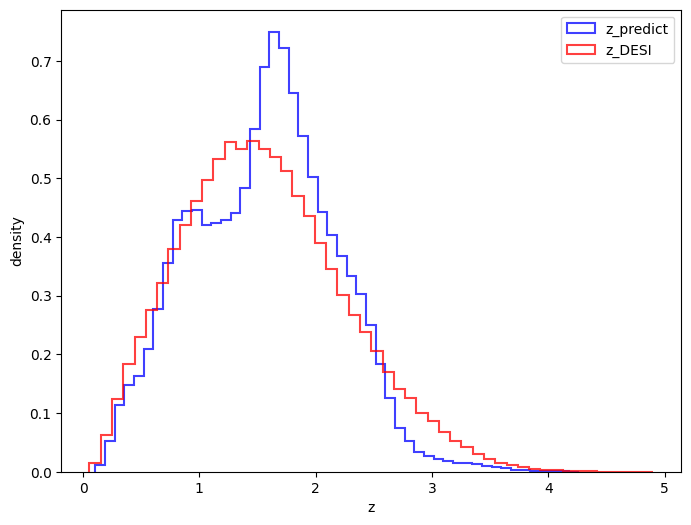

In [45]:
#히스토그램
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(zphot4_data['Photo_z_QD'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_predict')

plt.hist(data['DESI_Z'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_DESI')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

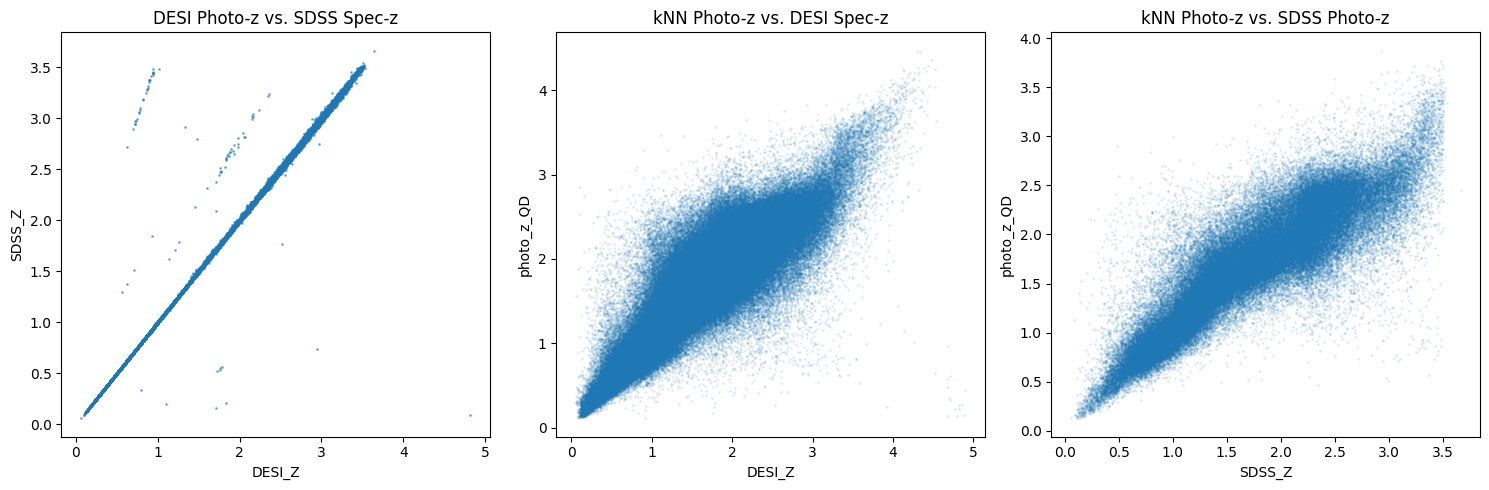

In [26]:
plt.figure(figsize=(15, 5))

# 1. Quaia vs. DESI
plt.subplot(1, 3, 1)
plt.scatter(data['DESI_Z'], data['SDSS_Z'], alpha=0.5, s=1)
plt.xlabel("DESI_Z")
plt.ylabel("SDSS_Z")
plt.title("DESI Photo-z vs. SDSS Spec-z")

# 2. kNN Photo-z vs. DESI
plt.subplot(1, 3, 2)
plt.scatter(data['DESI_Z'], zphot3_data['Photo_z_QD'], alpha=0.1, s=1)
plt.xlabel("DESI_Z")
plt.ylabel("photo_z_QD")
plt.title("kNN Photo-z vs. DESI Spec-z")

# 3. kNN Photo-z vs. Quaia
plt.subplot(1, 3, 3)
plt.scatter(data['SDSS_Z'], zphot4_data['Photo_z_QD'], alpha=0.1, s=1)
plt.xlabel("SDSS_Z")
plt.ylabel("photo_z_QD")
plt.title("kNN Photo-z vs. SDSS Photo-z")

plt.tight_layout()
plt.show()


SDSS only

In [54]:
train_mask = (~np.isnan(data['SDSS_Z'])) 
train_data = data[train_mask]

print("train_data 개수:", np.sum(train_mask))

features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg',
            'Quaia_W12'
            ]

valid_mask = (~np.isnan(data['SDSS_Z'])) 
filtered_data = data[valid_mask]

X_train = np.array([filtered_data[f] for f in features]).T
y_train = filtered_data['SDSS_Z']

X_test = np.array([filtered_data[f] for f in features]).T
# y_test = filtered_data['DESI_Z']    #doesn't need to be.. as I don't use it in the code practically.


print("X_train NaN 개수:", np.isnan(X_train).sum())
print("X_test NaN 개수:", np.isnan(X_test).sum())
print("X_test shape:", X_test.shape)
print("각 feature 별 NaN 개수:", np.isnan(X_test).sum(axis=0))
print("test_mask에서 True 개수:", np.sum(valid_mask))
print(filtered_data.shape)

# print(y_test)
print(y_train)

train_data 개수: 218546
X_train NaN 개수: 0
X_test NaN 개수: 0
X_test shape: (218546, 6)
각 feature 별 NaN 개수: [0 0 0 0 0 0]
test_mask에서 True 개수: 218546
(218546,)
[2.414      2.863      0.81013703 ... 0.579      2.454      2.411     ]


In [55]:
%load_ext memory_profiler
%memit

K = 11

nan_mask_test = np.isnan(X_test).any(axis=1)
X_test_clean = X_test[~nan_mask_test]

nan_mask = np.isnan(X_train).any(axis=1)  # NaN이 있는 행 찾기

X_train_clean = X_train[~nan_mask]  # NaN 없는 데이터만 선택
y_train_clean = y_train[~nan_mask]

tree = cKDTree(X_train_clean)
dists, inds = tree.query(X_test_clean, k=K)

# 거리 기반 가중치 적용 (가까울수록 더 높은 가중치)
#sigma = np.median(dists)  # 거리의 중앙값을 기준으로 스케일 조정
#weights = np.exp(-dists**2 / (2 * sigma**2))  # 가우시안 가중치 적용
#weights /= np.sum(weights, axis=1, keepdims=True)  # 정규화
#z_phot_predictions = np.sum(y_train_clean[inds] * weights, axis=1)

Y_neighbors = y_train_clean[inds]
# 모든 이웃에게 동일한 가중치 부여
weights = np.full_like(Y_neighbors, fill_value=1 / K, dtype=np.float64)

z_phot_predictions = np.sum(Y_neighbors * weights, axis=1)

# 결과 확인
count = 0  # 출력된 개수 카운트
max_print = 5  # 최대 출력 개수

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test] 

for i, pred in zip(valid_test_indices, z_phot_predictions):
    quaia = data['redshift_quaia'][i]
    desi = data['DESI_Z'][i]
    
    if not (np.isnan(pred) or np.isnan(quaia) or np.isnan(desi)):
        print(f"예측된 redshift: {pred}\nQuaia redshift: {quaia}\nDESI redshift: {desi}\n")
        count += 1

    if count >= max_print:
        break

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 1579.14 MiB, increment: 0.00 MiB
예측된 redshift: 2.5874699443470344
Quaia redshift: 2.4226319789886475
DESI redshift: 2.424188775557774

예측된 redshift: 2.423846417427063
Quaia redshift: 2.852853775024414
DESI redshift: 2.869778073634424

예측된 redshift: 0.6659598564668134
Quaia redshift: 0.821638286113739
DESI redshift: 0.8104069564257644

예측된 redshift: 0.688805885705081
Quaia redshift: 0.4740816652774811
DESI redshift: 0.4708462042020013

예측된 redshift: 1.756112129471519
Quaia redshift: 1.8770912885665894
DESI redshift: 1.8636456256865628



In [56]:
%load_ext memory_profiler
%memit

# X_test NaN 처리
imputer = SimpleImputer(strategy='mean')  # 평균값으로 NaN 대체

# 스케일링
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 스케일링 확인
for name, mean, var in zip(features, scaler.mean_, scaler.var_):
    print(f"{name}: mean = {mean:.4f}, std = {np.sqrt(var):.4f}")

#knn = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='euclidean')
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='euclidean')
knn.fit(X_train, y_train)

# kNN 예측
z_phot_predictions2 = knn.predict(X_test)

y_pred_train = knn.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
print(z_phot_predictions2[:5])

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 1667.82 MiB, increment: 0.00 MiB
phot_g_mean_mag: mean = 19.7595, std = 0.6218
phot_bp_mean_mag: mean = 19.9501, std = 0.6207
phot_rp_mean_mag: mean = 19.3095, std = 0.6176
mag_w1_vg: mean = 16.1162, std = 0.7894
mag_w2_vg: mean = 15.0581, std = 0.8219
Quaia_W12: mean = 1.0580, std = 0.2051
MAE: 0.2348, RMSE: 0.3248
[2.59163388 2.35926212 0.6494578  0.41086475 0.73334903]


/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [60]:
header = superset[1].header  

print("z_phot_predictions shape:", z_phot_predictions2.shape)
print("z_phot_predictions sample:", z_phot_predictions2[:10])

print("test_mask에서 True 개수:", np.sum(valid_mask))
print("X_test_clean shape:", X_test_clean.shape)

new_col_zphot = np.full(data.shape[0], np.nan) 
new_col_err = np.full(data.shape[0], np.nan)

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test]  

# 예측된 값 채우기
new_col_zphot[valid_test_indices] = z_phot_predictions
#new_col_err[valid_test_indices] = sigma_z

new_cols = fits.ColDefs([
    fits.Column(name='Photo_z_QD', format='E', array=new_col_zphot)
    #fits.Column(name='Photo_z_QD_err', format='E', array=new_col_err)
])

hdu = fits.BinTableHDU.from_columns(data.columns + new_cols, header=header)

hdu.writeto("superset_with_zphot_new5.fits", overwrite=True)


z_phot_predictions shape: (218546,)
z_phot_predictions sample: [2.59163388 2.35926212 0.6494578  0.41086475 0.73334903 1.61977722
 0.32052093 1.2878897  2.06340557 1.81323228]
test_mask에서 True 개수: 218546
X_test_clean shape: (218546, 6)


In [61]:
zphot5 = fits.open('superset_with_zphot_new5.fits')
zphot5_data = zphot5[1].data

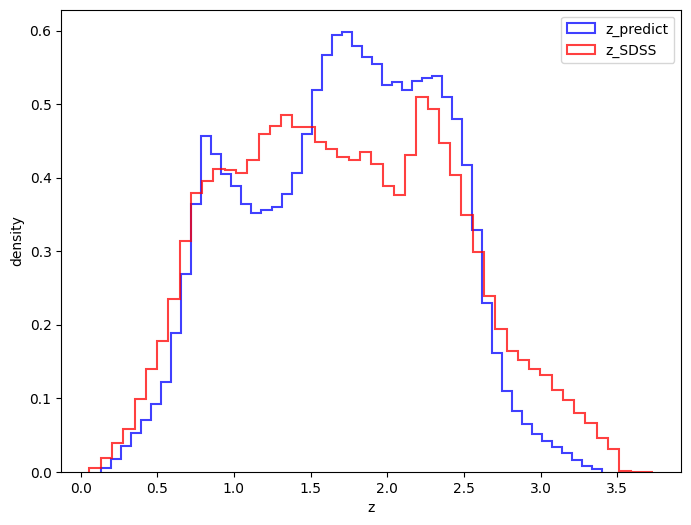

In [62]:
#히스토그램
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(zphot5_data['Photo_z_QD'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_predict')

plt.hist(data['SDSS_Z'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_SDSS')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

# 3. Checking all the fits data

kNN (kNeighborRegressor)

In [27]:
superset_kNR = fits.open('superset_with_zphot_kNR2.fits')
kNR_data = superset_kNR[1].data

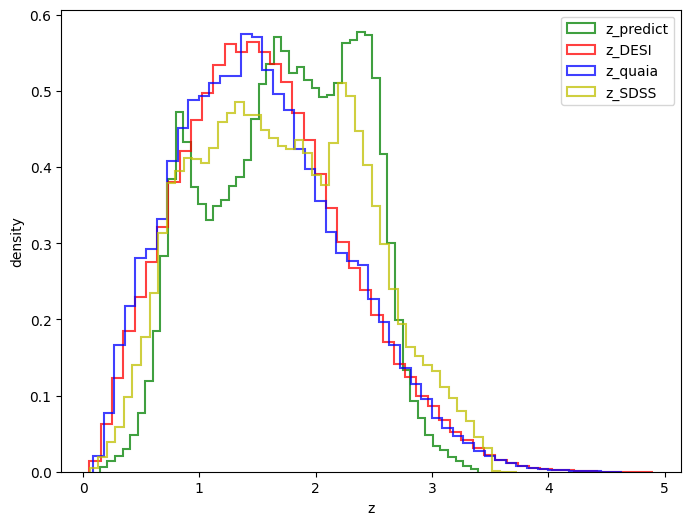

In [28]:
#히스토그램
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(kNR_data['Photo_z_QD'], bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(kNR_data['DESI_Z'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_DESI')
plt.hist(kNR_data['redshift_quaia'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_quaia')
plt.hist(kNR_data['SDSS_Z'], bins=50, alpha=alpha, color='y', lw=lw, density=density, histtype=histtype, label='z_SDSS')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

Text(0, 0.5, 'number per bin')

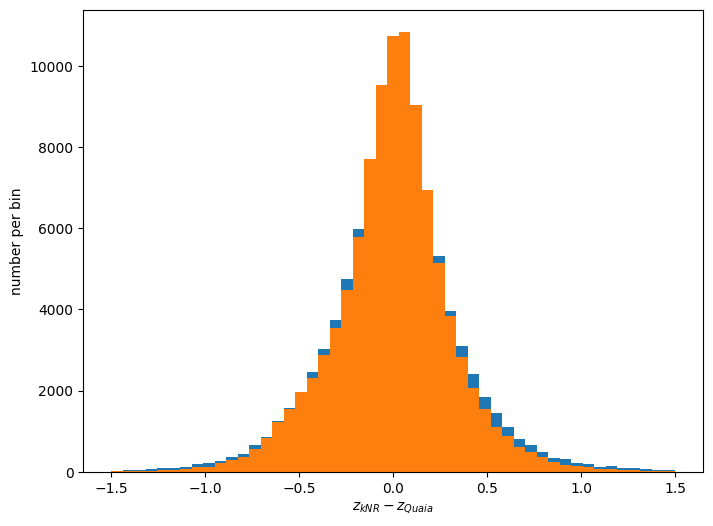

In [29]:
plt.figure(figsize=(8, 6))

bins = np.linspace(-1.5, 1.5, 50)
plt.hist(kNR_data['Photo_Z_QD'] - kNR_data['DESI_Z'], bins=bins)
plt.xlabel(r'$z_{kNR} - z_{DESI}$')
plt.ylabel('number per bin')

bins1 = np.linspace(-1.5, 1.5, 50)
plt.hist(kNR_data['Photo_Z_QD'] - kNR_data['redshift_quaia'], bins=bins1)
plt.xlabel(r'$z_{kNR} - z_{Quaia}$')
plt.ylabel('number per bin')

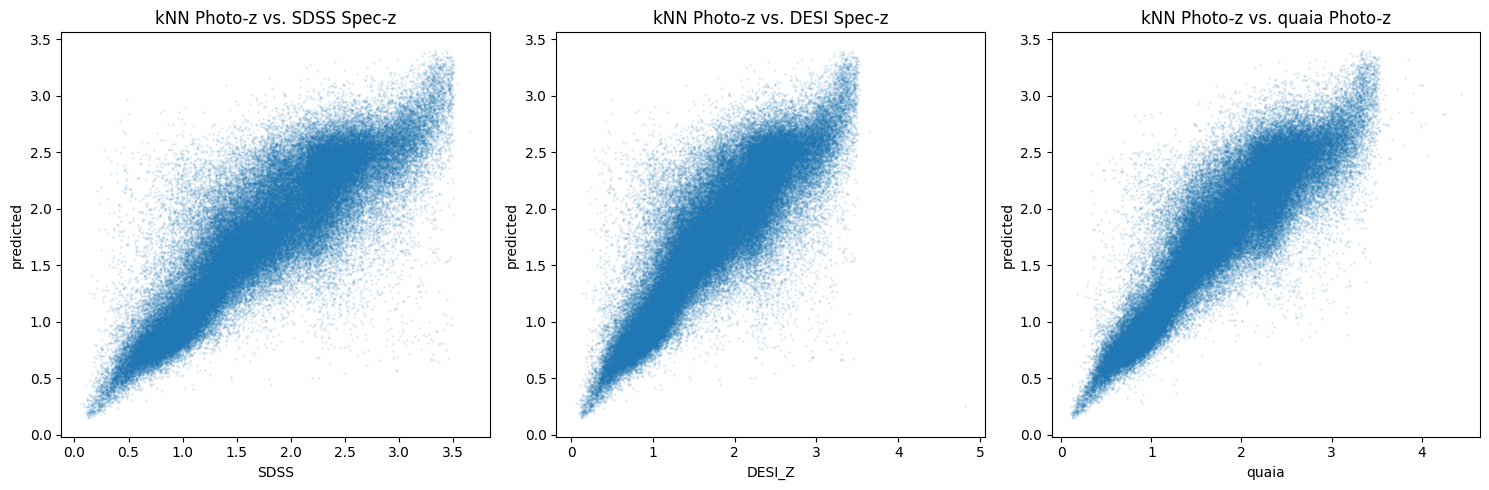

In [30]:
plt.figure(figsize=(15, 5))

# 1. Quaia vs. DESI
plt.subplot(1, 3, 1)
plt.scatter(kNR_data['SDSS_Z'], kNR_data['Photo_z_QD'], alpha=0.1, s=1)
plt.xlabel("SDSS")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. SDSS Spec-z")

# 2. kNN Photo-z vs. DESI
plt.subplot(1, 3, 2)
plt.scatter(kNR_data['DESI_Z'], kNR_data['Photo_z_QD'], alpha=0.1, s=1)
plt.xlabel("DESI_Z")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. DESI Spec-z")

# 3. kNN Photo-z vs. Quaia
plt.subplot(1, 3, 3)
plt.scatter(kNR_data['redshift_quaia'], kNR_data['Photo_z_QD'], alpha=0.1, s=1)
plt.xlabel("quaia")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. quaia Photo-z")

plt.tight_layout()
plt.show()


kNN (cKDTree)

In [31]:
z1 = fits.open('superset_with_z1.fits')
z1data = z1[1].data

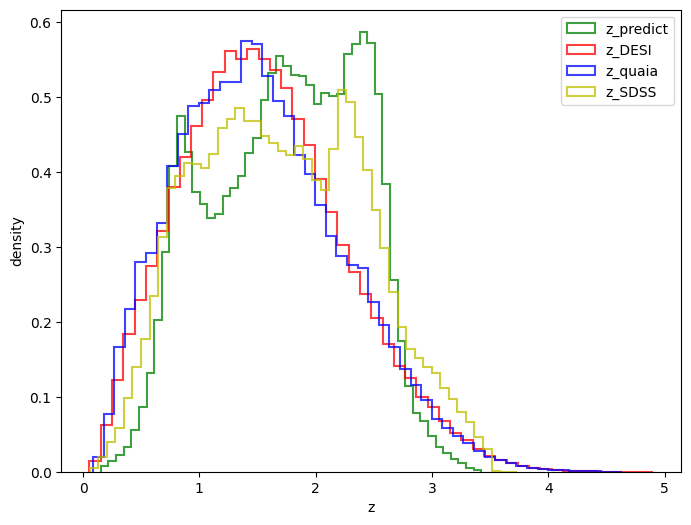

In [32]:
#히스토그램
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(z1data['Photo_z_QD'], bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(z1data['DESI_Z'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_DESI')
plt.hist(z1data['redshift_quaia'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_quaia')
plt.hist(z1data['SDSS_Z'], bins=50, alpha=alpha, color='y', lw=lw, density=density, histtype=histtype, label='z_SDSS')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

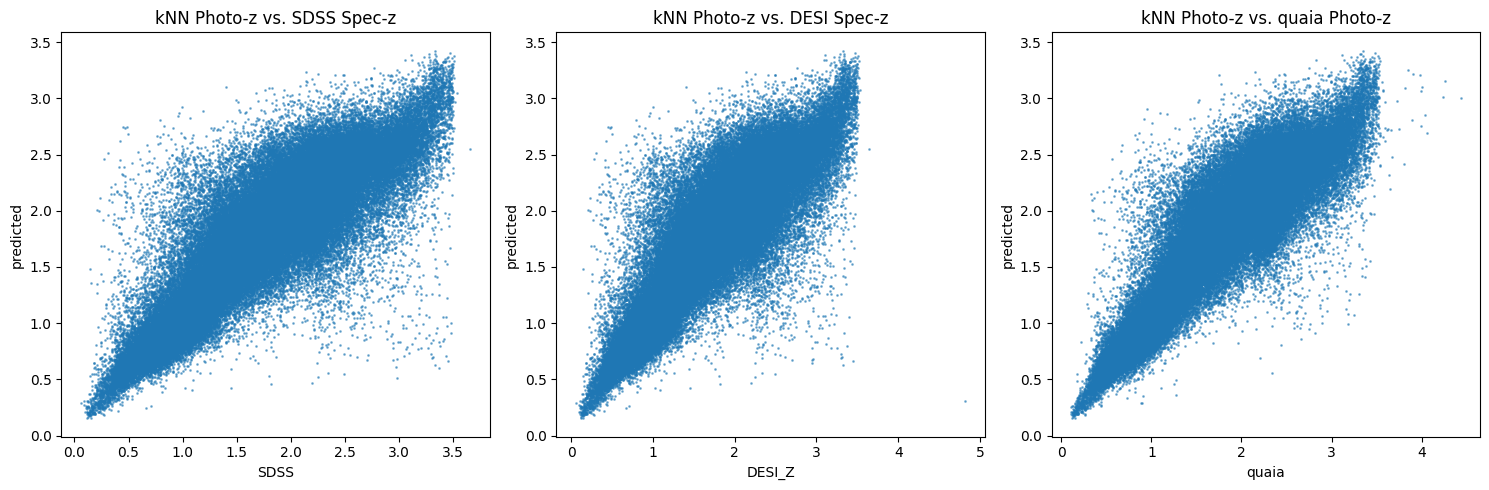

In [33]:
plt.figure(figsize=(15, 5))

# 1. Quaia vs. DESI
plt.subplot(1, 3, 1)
plt.scatter(z1data['SDSS_Z'], z1data['Photo_z_QD'], alpha=0.5, s=1)
plt.xlabel("SDSS")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. SDSS Spec-z")

# 2. kNN Photo-z vs. DESI
plt.subplot(1, 3, 2)
plt.scatter(z1data['DESI_Z'], z1data['Photo_z_QD'], alpha=0.5, s=1)
plt.xlabel("DESI_Z")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. DESI Spec-z")

# 3. kNN Photo-z vs. Quaia
plt.subplot(1, 3, 3)
plt.scatter(z1data['redshift_quaia'], z1data['Photo_z_QD'], alpha=0.5, s=1)
plt.xlabel("quaia")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. quaia Photo-z")

plt.tight_layout()
plt.show()
